In [1]:
import hoomd
import gsd.hoomd
import numpy
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt

In [2]:
s = gsd.hoomd.Snapshot()
s.particles.N = 2
s.particles.types = ['A']
s.particles.typeid = [0,0]
s.particles.position = [[1,1,1], [2,1,2]]
s.particles.orientation = [[1, 0, 0, 0], [0, math.cos((math.pi)/4), 0.0, math.cos((math.pi)/4)]]
s.configuration.box = [8, 8, 8, 0, 0, 0]
s.particles.mass = [2] * 2

/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/gsd/hoomd.py:420: FutureWarning: Snapshot is deprecated, use Frame
  warnings.warn("Snapshot is deprecated, use Frame", FutureWarning)


In [3]:
#Script in order to account for Intertia, which hopefully solves the line 9 problem of providing no torques
#The problem: adding the mass property to the particles breaks the line 4 command
general_positions = numpy.array([[0, 0, 0], [1, 0, 0]])

I_ref = numpy.array([[0.4, 0, 0],
                   [0, 0.4, 0],
                   [0, 0, 0.4]])
I_general = numpy.zeros(shape=(3,3))
for r in general_positions:
    I_general += I_ref + 1 * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))
    
I_diagonal, E_vec = numpy.linalg.eig(I_general)

R = E_vec.T

diagonal_positions = numpy.dot(R, general_positions.T).T

I_check = numpy.zeros(shape=(3,3))
for r in diagonal_positions:
    I_check += I_ref + 1 * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))

#mass = 1
#I = numpy.zeros(shape=(3,3))
#for r in central_position:
#    I += mass * (numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r))
I_check

array([[0.8, 0. , 0. ],
       [0. , 1.8, 0. ],
       [0. , 0. , 1.8]])

In [4]:
s.particles.moment_inertia = [I_general[0, 0], I_general[1, 1], I_general[2, 2]] * 2
print(s.particles.moment_inertia[:])

[0.8, 1.7999999999999998, 1.7999999999999998, 0.8, 1.7999999999999998, 1.7999999999999998]


In [5]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_snapshot(s)

In [6]:
rigid = hoomd.md.constrain.Rigid()

rigid.body['dimer'] = {
    "constituent_types": ['A', 'A'],
    "positions": [[0, 0, -0.5], [0, 0, 0.5]],
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0, 0, 1.0)],
    "charges": [0.0, 0.0],
    "diameters": [1.0, 1.0]
}

/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/hoomd/md/constrain.py:44: FutureWarning: The charges key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)
/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/hoomd/md/constrain.py:44: FutureWarning: The diameters key is deprecated and will be removed in hoomd 4.0.
  warnings.warn(msg, FutureWarning)


In [7]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)

cell = hoomd.md.nlist.Cell(buffer=0.4)

lperp = 0.3
lpar = 1.0
sigmin = 2 * min(lperp, lpar)
sigmax = 2 * max(lperp, lpar)

gay_berne = hoomd.md.pair.aniso.GayBerne(nlist=cell, default_r_cut=2.5)
gay_berne.params[('A', 'A')] = dict(epsilon=1.0, lperp=lperp, lpar=lpar)
gay_berne.r_cut[('A', 'A')] = 2.5

In [8]:
sim.operations.integrator = integrator

In [9]:
integrator.rigid = rigid

In [10]:
#sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

#kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
integrator.methods.append(nve)
integrator.forces.append(gay_berne)

/Users/noah/miniconda3/envs/try2/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [11]:
logger = hoomd.logging.Logger(categories=['scalar'])
# Log all default quantities of the lj object
logger += gay_berne
logger.add(gay_berne, quantities=['energy'])
#logger.add(cell, quantities=['pair_list'])

In [12]:
Table = hoomd.write.Table(output=open('gay_berne_log_different_directions.txt', mode='w', newline='\n'),
                          trigger = hoomd.trigger.Periodic(1), logger=logger)
sim.operations.writers.append(Table)

In [13]:
#sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free, kT=kT)
sim.run(0)
#nvt.thermalize_thermostat_dof()

In [14]:
g = sim.state.get_snapshot()
g.particles.orientation

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.70710677, 0.        , 0.70710677]])

In [15]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
gsd_writer = hoomd.write.GSD(filename = 'traj_different_directions.gsd', trigger = hoomd.trigger.Periodic(1), mode = 'wb', filter = hoomd.filter.All())
sim.operations.writers.append(gsd_writer)

In [16]:
sim.operations.computes.append(thermodynamic_properties)
sim.run(1000)

In [17]:
thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_quantities)

In [18]:
translational_degrees_of_freedom = thermodynamic_quantities.translational_degrees_of_freedom
print('Translational degrees of freedom:', translational_degrees_of_freedom)

Translational degrees of freedom: 6.0


In [19]:
thermodynamic_quantities.rotational_kinetic_energy

7.488177903553524

In [20]:
print(s.particles.moment_inertia[:])

[[0.8 1.8 1.8]
 [0.8 1.8 1.8]]


In [21]:
print(s.particles.orientation)

[[1.         0.         0.         0.        ]
 [0.         0.70710677 0.         0.70710677]]


In [22]:
f = gsd.hoomd.open('traj_different_directions.gsd', 'r')

In [61]:
#To finish later
def distconvert(dist, lperp, lpar, ei, ej):
    sigmin = min(lperp, lpar) * 2
    H = 2 * (lperp**2) * np.identity(3) + ((lpar**2 - lperp**2) * (np.outer(ei, ei) + np.outer(ej, ej)))
    sigma = (np.dot((0.5*dist) , np.dot(np.linalg.inv(H), dist)))**(-2)
    #print(H**(-1))
    gbdist = ((np.linalg.norm(dist) - sigma + sigmin) / sigmin)
    return np.abs(gbdist)

In [62]:
def phiconvert(dist, lperp, lpar, ei, ej):
    sigmin = min(lperp, lpar) * 2
    H = 2 * (lperp**2) * np.identity(3) + ((lpar**2 - lperp**2) * (np.outer(ei, ei) + np.outer(ej, ej)))
    sigma = (np.dot((0.5*dist) , np.dot(np.linalg.inv(H), dist)))**(-2)
    #print(H**(-1))
    gbdist = np.dot((0.5*dist) , np.dot(np.linalg.inv(H), dist))
    return np.abs(gbdist)

In [40]:
print(frame.configuration.box, type(frame.configuration.box))

[8. 8. 8. 0. 0. 0.] <class 'numpy.ndarray'>


In [63]:
distances = []
gbdists = []
phidists = []
for frame in f:
    #Adjust for periodic boundaries
    #distvect = frame.particles.position[1] - frame.particles.position[0]
    dx, dy, dz = frame.particles.position[1] - frame.particles.position[0]
    dx = np.sign(dx) * (np.abs(dx) %(frame.configuration.box[0]/2))
    dy = np.sign(dy) * (np.abs(dy) %(frame.configuration.box[1]/2))
    dz = np.sign(dz) * (np.abs(dz) %(frame.configuration.box[2]/2))
    distvect = np.array([dx, dy, dz])
    distnorm = numpy.linalg.norm(distvect)
    distances.append(distnorm)
    ei = frame.particles.orientation[0][1:]
    ei = ei / np.linalg.norm(ei)
    ej = frame.particles.orientation[1][1:]
    ej = ej / np.linalg.norm(ej)
    gbdists.append(distconvert(distvect, lperp, lpar, ei, ej))
    phidists.append(phiconvert(distvect, lperp, lpar, ei, ej))

print(gbdists)

[1.3991436115944185, 1.4599392518408456, 1.5460253530111199, 1.6449457450966767, 1.7483317521824053, 1.8515153828128128, 1.952196380577153, 2.0493921122933703, 2.142804460746277, 2.2324591170291033, 2.318527740735379, 2.4017270708632084, 2.4822217242435927, 2.5601652315472485, 2.6357004639811263, 2.708961989590984, 2.780074311434648, 2.8491549298188343, 2.916313721014363, 2.981653158656251, 3.0452700717345955, 3.1072536914978675, 3.1676905309283985, 3.226659105946813, 3.2842349666093025, 3.340488802136364, 3.395486951897741, 3.4492923238171778, 3.501963685592505, 3.5535566684623396, 3.6041237225171447, 3.6537144411121623, 3.702375655985467, 3.7501515165450794, 3.7970838192626384, 3.843212334871807, 3.888574158262703, 3.933205122120672, 3.9771387838713057, 4.020406798598807, 4.063039013927948, 4.105064401779152, 4.146509845938222, 4.187401403862584, 4.227763474318643, 4.267619458048069, 4.306991405814496, 4.345900415771855, 4.384366519328072, 4.422408717179898, 4.4600451736060664, 4.497

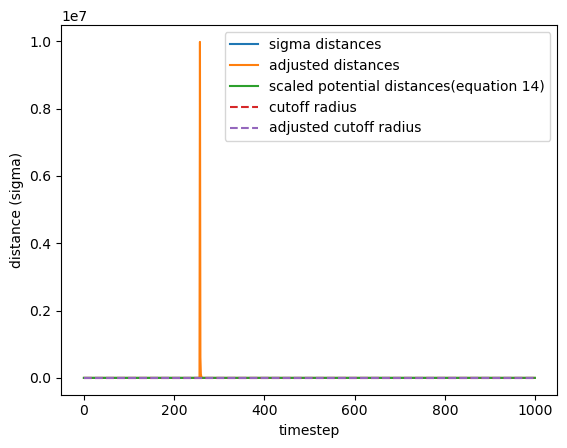

In [64]:
plt.figure()
plt.plot(distances, label = 'sigma distances')
plt.plot(gbdists, label = 'adjusted distances')
plt.plot(phidists, label = 'scaled potential distances(equation 14)')
plt.xlabel('timestep')
plt.ylabel('distance (sigma)')
plt.plot(2.5 * numpy.ones_like(distances), ls = '--', label = 'cutoff radius')
plt.plot(((2.5 - sigmax + sigmin)/sigmin) * numpy.ones_like(distances), ls = '--', label = 'adjusted cutoff radius')
#plt.axvline(x = 490, color = 'g', label = 'vertical line') #This is the function for a vertical line but
#plt.ylim(-10, 8)
plt.legend()

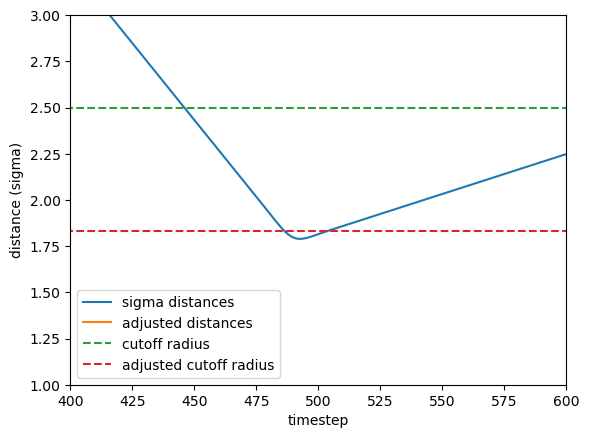

In [26]:
plt.figure()
plt.plot(distances, label = 'sigma distances')
plt.plot(gbdists, label = 'adjusted distances')
plt.xlabel('timestep')
plt.ylabel('distance (sigma)')
plt.plot(2.5 * numpy.ones_like(distances), ls = '--', label = 'cutoff radius')
plt.plot(((2.5 - sigmax + sigmin)/sigmin) * numpy.ones_like(distances), ls = '--', label = 'adjusted cutoff radius')
#plt.axvline(x = 490, color = 'g', label = 'vertical line') #This is the function for a vertical line but
plt.axis([400, 600, 1, 3])
plt.legend()

In [27]:
#To do list:
# Get the quaternions like we did the positions so we can calculate adjusted distances
# Plot the adjusted distances
# Put a veritcal line on the plot at index where energies hit zero
# Make a zoomed in plot of the interesting area (index 0-10)

In [28]:
firstframe = f[0]

In [29]:
firstframe.particles.orientation

array([[ 9.9999988e-01,  0.0000000e+00, -5.2709749e-04,  0.0000000e+00],
       [ 0.0000000e+00,  7.0747942e-01,  0.0000000e+00,  7.0673394e-01]],
      dtype=float32)

In [30]:
np.linalg.norm(firstframe.particles.orientation[0][1:])

0.0005270975